<a href="https://colab.research.google.com/github/saxenam06/Image_search_UserText/blob/main/Search_Image_LargeEmbeddingsDataset_fromInputText_UsingBLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install requirements

In [2]:
!pip3 install pyspark
!pip install ipython-autotime
%load_ext autotime

time: 299 µs (started: 2023-09-07 10:17:15 +00:00)


### Load Libraries

In [3]:
!pip install timm fairscale transformers
!pip install datasets torch
# install requirements
from pyspark import SparkFiles
import zipfile
import torch
import shutil
from torchvision.transforms.functional import InterpolationMode
import json
import os.path as osp
import os
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, explode, PandasUDFType, lit
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, BinaryType, DoubleType, FloatType, IntegerType

time: 33.7 s (started: 2023-09-07 10:17:15 +00:00)


### Create Spark Session

In [4]:
spark = SparkSession.builder.appName("Images_Embed").getOrCreate()
spark

time: 15.5 s (started: 2023-09-07 10:17:49 +00:00)


### Optimize configuration (As of now default!)

In [5]:
sc = spark.sparkContext
sc.getConf().getAll()

[('spark.app.id', 'local-1694081877480'),
 ('spark.app.name', 'Images_Embed'),
 ('spark.app.startTime', '1694081874927'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.securi

time: 86.8 ms (started: 2023-09-07 10:18:04 +00:00)


### Download BLIP repository

In [6]:
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/BLIP
    %cd

Running in Colab.
fatal: destination path 'BLIP' already exists and is not an empty directory.
/root
time: 146 ms (started: 2023-09-07 10:18:04 +00:00)


### Distribute BLIP repository to every Spark executor node

In [7]:
sc = spark.sparkContext

# Distribute the ZIP archives
shutil.make_archive("/content/BLIP/models_zip", 'zip', "/content/BLIP", "models")
shutil.make_archive("/content/BLIP/configs_zip", 'zip', "/content/BLIP", "configs")

# Add the ZIP files to Spark
models_zip_path = '/content/BLIP/models_zip.zip'
configs_zip_path = '/content/BLIP/configs_zip.zip'

sc = spark.sparkContext
sc.addPyFile(models_zip_path)
sc.addPyFile(configs_zip_path)

sys.path.append('/content/BLIP/models')
sys.path.append('/content/BLIP/configs')

time: 319 ms (started: 2023-09-07 10:18:05 +00:00)


### Retrieve Stored Image Embeddings

In [8]:
destination_directory = '/content/drive/MyDrive/Frame_Embeds'
image_embeds_df = spark.read.format("parquet") \
  .load(destination_directory)

time: 7.1 s (started: 2023-09-07 10:18:05 +00:00)


### Define User Text w.r.t which Similarity Search over Image Dataset need to be performed.

In [9]:
search_caption = 'a car driving on an intersection'

time: 881 µs (started: 2023-09-07 10:18:12 +00:00)


### Load BLIP model- model_base_retrieval_coco and Tokeninze the User text

In [10]:
%cd '/content/BLIP'
from models.blip_itm import blip_itm
def initialize_blip_itm_model():
    model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    model = blip_itm(pretrained=model_url, image_size=384, vit='base')
    model.eval()
    model = model.to(device='cpu')
    return model

model = initialize_blip_itm_model()
text = model.tokenizer(search_caption, padding='max_length', truncation=True, max_length=35,
                              return_tensors="pt").to('cpu')

/content/BLIP
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
time: 46.8 s (started: 2023-09-07 10:18:12 +00:00)


### Wrap model in Pandas UDF and Do distributed inference for Creating Similarity Scores for each Image Embedding  w.r.t User Text

In [11]:
schema = StructType([
    StructField('ITMScore', FloatType())
])

# Define a UDF to reshape the 'Embeddings' column
@pandas_udf(schema)
def calculate_scores(embeddings_series: pd.Series) -> pd.DataFrame:
    itm_scores = []

    models_zip_path_on_workers = SparkFiles.get('models_zip.zip')
    configs_zip_path_on_workers = SparkFiles.get('configs_zip.zip')

    models_subdirectory_path = '/content/'
    configs_subdirectory_path = '/content/'
    search_caption = 'a car driving on an intersection'
    print(f"Extracting models to {models_subdirectory_path}")
    with zipfile.ZipFile(models_zip_path_on_workers, 'r') as zip_ref:
        zip_ref.extractall(models_subdirectory_path)

    print(f"Extracting models to {configs_subdirectory_path}")
    with zipfile.ZipFile(configs_zip_path_on_workers, 'r') as zip_ref:
        zip_ref.extractall(configs_subdirectory_path)

    med_config_path = '/content/configs/med_config.json'
    with open(med_config_path, 'r', encoding='utf-8') as reader:
        med_config_content = reader.read()
    print(f"med_config_path: {med_config_path}")
    model = initialize_blip_itm_model()
    model.eval()

    for embeddings in embeddings_series:
        original_shape = (1, 577, 768)
        image_embeds = torch.tensor(embeddings, dtype=torch.float32).view(original_shape)
        image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long)
        output = model.text_encoder(
            text.input_ids,  # Use the external input text_input_id
            attention_mask = text.attention_mask,  # Assuming text is defined somewhere
            encoder_hidden_states = image_embeds,
            encoder_attention_mask = image_atts,
            return_dict=True,
        )
        itm_output = model.itm_head(output.last_hidden_state[:,0,:])
        itm_score = torch.nn.functional.softmax(itm_output, dim=1)[:, 1].squeeze().detach().cpu().numpy()
        itm_scores.append(itm_score.tolist())
    return pd.DataFrame({'ITMScore': itm_scores})  # Convert the tensor to a Python list

# Apply the UDF to reshape the 'Embeddings' column
image_scores_df = image_embeds_df.withColumn('Scores', calculate_scores('Embeddings.Embeddings'))
image_scores_df.show(2)

+-------------+--------------------+-------------+
|     Frame_id|          Embeddings|       Scores|
+-------------+--------------------+-------------+
|1619829338500|{[-0.71700764, 0....| {0.01373761}|
|1619829255000|{[-0.76048744, 0....|{0.006370521}|
+-------------+--------------------+-------------+
only showing top 2 rows

time: 51.6 s (started: 2023-09-07 10:18:59 +00:00)


### Cache the Scores DataFrame and Write the Scores in Parquet format

In [12]:
# Select and write the desired columns
image_scores_df.cache()
image_scores_df.select("Frame_id", "Scores") \
        .write.mode("overwrite") \
        .parquet("Frame_Scores")

time: 3min 6s (started: 2023-09-07 10:19:51 +00:00)


### Store the Scores to desired folder

In [13]:
result_path = '/content/Frame_Scores'
destination_directory = '/content/drive/MyDrive/Frame_Scores'
shutil.rmtree(destination_directory, ignore_errors=True)
shutil.copytree(result_path, destination_directory)

'/content/drive/MyDrive/Frame_Scores'

time: 112 ms (started: 2023-09-07 10:22:57 +00:00)


### Read the Scores in Pandas dataframe

In [14]:
df = pd.read_parquet(result_path, engine='pyarrow')
df['ITMScore'] = df['Scores'].apply(lambda x: x['ITMScore'])

time: 605 ms (started: 2023-09-07 10:22:57 +00:00)


### Find the Images with Maximum Scores and Plot the Images from the dataset drive

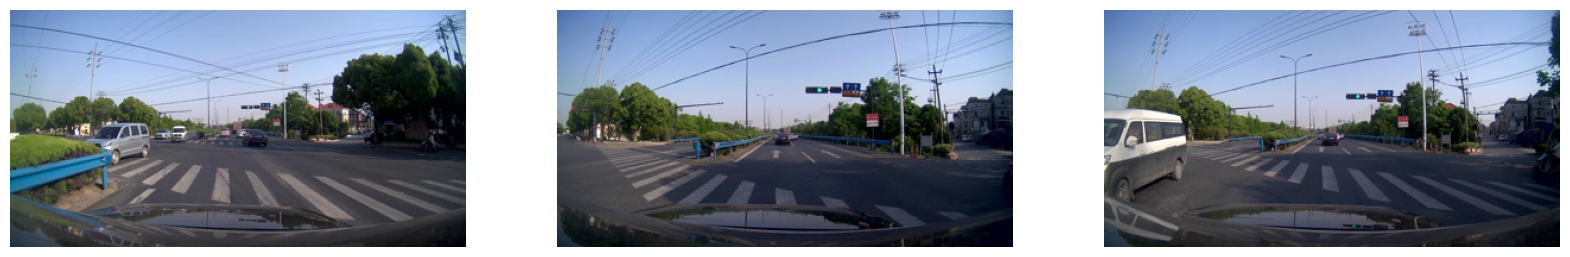

time: 4.16 s (started: 2023-09-07 10:22:57 +00:00)


In [15]:
data_path = "/content/drive/MyDrive"
train_split_igs_folder = "ONCE_Training_split_cam_igs_unzip"
train_split_igs_path = osp.join(data_path, train_split_igs_folder, 'data', '000495')

top_3 = df.nlargest(3, 'ITMScore')
frame_id_paths = top_3['Frame_id'].apply(lambda x: osp.join(train_split_igs_path, 'cam01', x)) + '.jpg'

from PIL import Image

plt.figure(figsize=(20, 20))

for i in range(len(frame_id_paths)):
    image_path = frame_id_paths.iloc[i]
    img = Image.open(image_path).resize((384, 200))

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.show()